Using device: cpu
Using dtype: torch.float32
Running PyTorch simulations...
  Sequence Length n = 256, Dimension d = 512, Batch Size = 4
    PyTorch Transformer Attention Time: 0.122304 seconds
    PyTorch Hyena Convolution Time:   0.110534 seconds
  Sequence Length n = 512, Dimension d = 512, Batch Size = 4
    PyTorch Transformer Attention Time: 0.114835 seconds
    PyTorch Hyena Convolution Time:   0.124928 seconds
  Sequence Length n = 1024, Dimension d = 512, Batch Size = 4
    PyTorch Transformer Attention Time: 0.313366 seconds
    PyTorch Hyena Convolution Time:   0.253595 seconds
  Sequence Length n = 2048, Dimension d = 512, Batch Size = 4
    PyTorch Transformer Attention Time: 1.042004 seconds
    PyTorch Hyena Convolution Time:   0.280873 seconds
  Sequence Length n = 4096, Dimension d = 512, Batch Size = 4
    PyTorch Transformer Attention Time: 2.451877 seconds
    PyTorch Hyena Convolution Time:   1.002394 seconds
  Sequence Length n = 8192, Dimension d = 512, Batch Siz

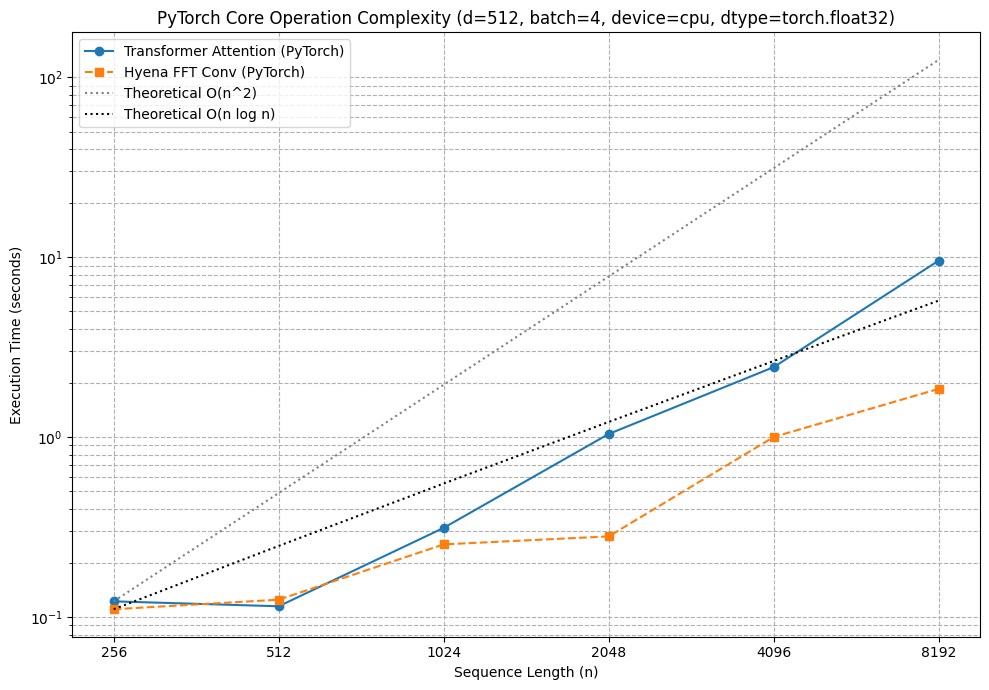


Note:
1. This compares core PyTorch operations, not full models.
2. Transformer O(n^2) scaling is evident in the steeper slope.
3. Hyena's O(n log n) FFT convolution scales much better.
4. Memory errors (OOM) likely occur much earlier for Transformer.
5. Actual speed depends heavily on hardware, batch size, and specific implementation optimizations.


In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dtype = torch.float16 if device.type == 'cuda' else torch.float32
print(f"Using dtype: {dtype}")

def measure_time(func, *args):
    if device.type == 'cuda':
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
    else:
        start_time = time.perf_counter()
    result = func(*args)
    if device.type == 'cuda':
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms = start_event.elapsed_time(end_event)
        return elapsed_time_ms / 1000.0
    else:
        end_time = time.perf_counter()
        return end_time - start_time

def pytorch_transformer_attention(n, d, batch_size=1):
    try:
        x = torch.randn(batch_size, n, d, device=device, dtype=dtype)
        wq = torch.nn.Linear(d, d, bias=False, device=device, dtype=dtype)
        wk = torch.nn.Linear(d, d, bias=False, device=device, dtype=dtype)
        wv = torch.nn.Linear(d, d, bias=False, device=device, dtype=dtype)
        def compute():
            q = wq(x)
            k = wk(x)
            v = wv(x)
            scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(d)
            output = torch.bmm(scores, v)
            return output
        exec_time = measure_time(compute)
        return exec_time
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        print(f"OOM/RuntimeError for Transformer attention at n={n}: {e}")
        if 'cuda' in str(e).lower() and device.type == 'cuda':
             torch.cuda.empty_cache()
        return None

def pytorch_hyena_convolution(n, d, batch_size=1):
    try:
        x = torch.randn(batch_size, d, n, device=device, dtype=dtype)
        h_filter = torch.randn(batch_size, d, n, device=device, dtype=dtype)
        fft_len = 2 * n - 1
        def compute():
            x_padded = torch.nn.functional.pad(x, (0, fft_len - n))
            h_padded = torch.nn.functional.pad(h_filter, (0, fft_len - n))
            fft_x = torch.fft.rfft(x_padded, n=fft_len, dim=-1)
            fft_h = torch.fft.rfft(h_padded, n=fft_len, dim=-1)
            fft_product = fft_x * fft_h
            ifft_result = torch.fft.irfft(fft_product, n=fft_len, dim=-1)
            output = ifft_result[..., :n]
            return output
        exec_time = measure_time(compute)
        return exec_time
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        print(f"OOM/RuntimeError for Hyena convolution at n={n}: {e}")
        if 'cuda' in str(e).lower() and device.type == 'cuda':
             torch.cuda.empty_cache()
        return None

n_values = [2**i for i in range(8, 14)]
d = 512
batch_size = 4
transformer_times_pytorch = []
hyena_times_pytorch = []
num_runs = 3

print("Running PyTorch simulations...")
for n in n_values:
    print(f"  Sequence Length n = {n}, Dimension d = {d}, Batch Size = {batch_size}")
    t_run_times = []
    oom_transformer = False


    for _ in range(num_runs):
        t = pytorch_transformer_attention(n, d, batch_size)
        if t is None:
            oom_transformer = True
            break
        t_run_times.append(t)
        torch.cuda.empty_cache()
    if not oom_transformer:
        t_time_avg = sum(t_run_times) / num_runs
        transformer_times_pytorch.append(t_time_avg)
        print(f"    PyTorch Transformer Attention Time: {t_time_avg:.6f} seconds")
    else:
        transformer_times_pytorch.append(None)
        print("    PyTorch Transformer Attention failed (OOM/Runtime Error)")


    h_run_times = []
    oom_hyena = False
    for _ in range(num_runs):
        h = pytorch_hyena_convolution(n, d, batch_size)
        if h is None:
            oom_hyena = True
            break
        h_run_times.append(h)
        torch.cuda.empty_cache()
    if not oom_hyena:
        h_time_avg = sum(h_run_times) / num_runs
        hyena_times_pytorch.append(h_time_avg)
        print(f"    PyTorch Hyena Convolution Time:   {h_time_avg:.6f} seconds")
    else:
        hyena_times_pytorch.append(None)
        print("    PyTorch Hyena Convolution failed (OOM/Runtime Error)")

print("Simulations complete.")

plt.figure(figsize=(10, 7))
valid_indices_transformer = [i for i, t in enumerate(transformer_times_pytorch) if t is not None]
valid_n_transformer = [n_values[i] for i in valid_indices_transformer]
valid_times_transformer = [transformer_times_pytorch[i] for i in valid_indices_transformer]
valid_indices_hyena = [i for i, t in enumerate(hyena_times_pytorch) if t is not None]
valid_n_hyena = [n_values[i] for i in valid_indices_hyena]
valid_times_hyena = [hyena_times_pytorch[i] for i in valid_indices_hyena]
if valid_times_transformer:
    plt.plot(valid_n_transformer, valid_times_transformer, marker='o', linestyle='-', label=f'Transformer Attention (PyTorch)')
if valid_times_hyena:
    plt.plot(valid_n_hyena, valid_times_hyena, marker='s', linestyle='--', label=f'Hyena FFT Conv (PyTorch)')
C1 = valid_times_transformer[0] / (valid_n_transformer[0]**2) if valid_times_transformer else 0.00000001
C2 = valid_times_hyena[0] / (valid_n_hyena[0] * np.log2(valid_n_hyena[0])) if valid_times_hyena else 0.0000001
n_theory = np.array(n_values)
if valid_times_transformer:
    plt.plot(n_theory, C1 * (n_theory**2), color='gray', linestyle=':', label='Theoretical O(n^2)')
if valid_times_hyena:
    plt.plot(n_theory, C2 * n_theory * np.log2(n_theory), color='black', linestyle=':', label='Theoretical O(n log n)')
plt.xlabel("Sequence Length (n)")
plt.ylabel("Execution Time (seconds)")
plt.title(f"PyTorch Core Operation Complexity (d={d}, batch={batch_size}, device={device}, dtype={dtype})")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.yscale('log')
plt.xscale('log', base=2)
plt.xticks(n_values, labels=[str(n) for n in n_values])
plt.tight_layout()
plt.show()

print("\nNote:")
print("1. This compares core PyTorch operations, not full models.")
print("2. Transformer O(n^2) scaling is evident in the steeper slope.")
print("3. Hyena's O(n log n) FFT convolution scales much better.")
print("4. Memory errors (OOM) likely occur much earlier for Transformer.")
print("5. Actual speed depends heavily on hardware, batch size, and specific implementation optimizations.")
